# Libraries / Dependencies

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from pathlib import Path
from tqdm import tqdm
import shutil
from sklearn.model_selection import train_test_split
import pandas as pd
from collections import Counter


# Class Artstyle
 Using Dataset

In [2]:
class ArtStyleDataset(Dataset):
    """
    Dataset do pracy z obrazami podzielonymi według stylów artystycznych.
    """
    def __init__(self, data_dir, transform=None, mode='train'):
        """
        Args:
            data_dir: Katalog z danymi
            transform: Transformacje do zastosowania na obrazach
            mode: 'train', 'val' lub 'test'
        """
        self.data_dir = Path(data_dir) / mode
        self.transform = transform
        self.mode = mode
        
        # Znajdź wszystkie obrazy i ich style
        self.images = []
        self.labels = []
        self.label_to_idx = {}
        
        # Iteruj przez katalogi stylów
        for style_dir in self.data_dir.iterdir():
            if style_dir.is_dir():
                style_name = style_dir.name
                
                # Dodaj styl do słownika etykiet, jeśli go jeszcze nie ma
                if style_name not in self.label_to_idx:
                    self.label_to_idx[style_name] = len(self.label_to_idx)
                
                # Znajdź wszystkie obrazy w tym stylu
                for img_path in style_dir.glob('*.jpg'):
                    self.images.append(str(img_path))
                    self.labels.append(self.label_to_idx[style_name])
                
                for img_path in style_dir.glob('*.png'):
                    self.images.append(str(img_path))
                    self.labels.append(self.label_to_idx[style_name])
                
                for img_path in style_dir.glob('*.jpeg'):
                    self.images.append(str(img_path))
                    self.labels.append(self.label_to_idx[style_name])
        
        self.idx_to_label = {v: k for k, v in self.label_to_idx.items()}
        print(f"Znaleziono {len(self.images)} obrazów w zbiorze {mode} z {len(self.label_to_idx)} klasami")
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        
        # Wczytaj obraz
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            img = self.transform(img)
        
        return img, label, img_path


# Image Processing

In [3]:
def preprocess_images(input_dir, output_dir, target_size=(512, 512)):
    """
    Przetwarza obrazy z folderu wejściowego i zapisuje je w folderze wyjściowym
    z zachowaniem struktury katalogów (stylu artystycznego).
    
    Args:
        input_dir: Ścieżka do folderu z oryginalnymi obrazami
        output_dir: Ścieżka do folderu, w którym zostaną zapisane przetworzone obrazy
        target_size: Docelowy rozmiar obrazów (szerokość, wysokość)
    """
    input_path = Path(input_dir)
    output_path = Path(output_dir)
    
    # Upewnij się, że folder wyjściowy istnieje
    output_path.mkdir(parents=True, exist_ok=True)
    
    # Iteruj przez style artystyczne (główne foldery)
    style_dirs = [d for d in input_path.iterdir() if d.is_dir()]
    
    for style_dir in style_dirs:
        style_name = style_dir.name
        output_style_dir = output_path / style_name
        output_style_dir.mkdir(exist_ok=True)
        
        # Znajdź podfoldery (uwzględnienie podwójnego zagnieżdżenia)
        sub_dirs = [d for d in style_dir.iterdir() if d.is_dir()]
        
        # Jeśli istnieją podfoldery, wejdź do nich
        if sub_dirs:
            for sub_dir in sub_dirs:
                # Przetwórz wszystkie obrazy w danym podkatalogu
                image_files = list(sub_dir.glob('*.jpg')) + list(sub_dir.glob('*.png')) + list(sub_dir.glob('*.jpeg'))
                print(f"Przetwarzanie {len(image_files)} obrazów w stylu {style_name}")
                
                for img_path in tqdm(image_files, desc=f"Styl: {style_name}"):
                    process_image(img_path, output_style_dir, target_size)
        else:
            # Jeśli nie ma podfolderów, przetwórz obrazy bezpośrednio w głównym folderze stylu
            image_files = list(style_dir.glob('*.jpg')) + list(style_dir.glob('*.png')) + list(style_dir.glob('*.jpeg'))
            print(f"Przetwarzanie {len(image_files)} obrazów w stylu {style_name}")
            
            for img_path in tqdm(image_files, desc=f"Styl: {style_name}"):
                process_image(img_path, output_style_dir, target_size)
    
    print("Zakończono preprocessing obrazów!")

def process_image(img_path, output_dir, target_size):
    """
    Przetwarza pojedynczy obraz.
    
    Args:
        img_path: Ścieżka do obrazu
        output_dir: Katalog wyjściowy
        target_size: Docelowy rozmiar obrazu
    """
    try:
        # Wczytaj obraz
        img = cv2.imread(str(img_path))
        if img is None:
            print(f"Nie udało się wczytać: {img_path}")
            return
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Konwersja BGR na RGB
        
        # Sprawdź proporcje obrazu
        h, w = img.shape[:2]
        aspect_ratio = w / h
        
        # Sprawdź, czy obraz jest znacznie dłuższy w jednym z wymiarów
        if aspect_ratio > 3 or aspect_ratio < 1/3:
            # Obraz jest bardzo szeroki lub bardzo wysoki - przycinamy środek
            if w > h:
                # Szeroki obraz
                new_w = int(h * 1.5)  # Przytnij do proporcji 3:2
                start_x = int((w - new_w) / 2)
                img = img[:, start_x:start_x+new_w]
            else:
                # Wysoki obraz
                new_h = int(w * 1.5)  # Przytnij do proporcji 2:3
                start_y = int((h - new_h) / 2)
                img = img[start_y:start_y+new_h, :]
        
        # Skaluj obraz, zachowując proporcje
        h, w = img.shape[:2]
        if w > h:
            new_w = min(w, target_size[0])
            new_h = int(h * (new_w / w))
        else:
            new_h = min(h, target_size[1])
            new_w = int(w * (new_h / h))
        
        img_resized = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)
        
        # Utwórz pusty obraz o docelowym rozmiarze (dodaj padding)
        padded_img = np.zeros((target_size[1], target_size[0], 3), dtype=np.uint8)
        
        # Umieść przeskalowany obraz na środku
        start_x = (target_size[0] - new_w) // 2
        start_y = (target_size[1] - new_h) // 2
        padded_img[start_y:start_y+new_h, start_x:start_x+new_w] = img_resized
        
        # Zapisz przetworzony obraz
        output_file = output_dir / img_path.name
        cv2.imwrite(str(output_file), cv2.cvtColor(padded_img, cv2.COLOR_RGB2BGR))
        
    except Exception as e:
        print(f"Błąd podczas przetwarzania {img_path}: {e}")

# Datasplitting
train, validation, test

In [4]:
def split_data(processed_dir, output_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, random_state=42):
    """
    Dzieli dane na zbiory treningowy, walidacyjny i testowy.
    
    Args:
        processed_dir: Katalog z przetworzonymi obrazami
        output_dir: Katalog wyjściowy do zapisania podzielonych danych
        train_ratio: Proporcja zbioru treningowego
        val_ratio: Proporcja zbioru walidacyjnego
        test_ratio: Proporcja zbioru testowego
        random_state: Ziarno losowości dla powtarzalności wyników
    """
    assert train_ratio + val_ratio + test_ratio == 1.0, "Proporcje podziału muszą sumować się do 1.0"
    
    processed_path = Path(processed_dir)
    output_path = Path(output_dir)
    
    # Utwórz katalogi dla zbiorów
    train_dir = output_path / "train"
    val_dir = output_path / "val"
    test_dir = output_path / "test"
    
    for directory in [train_dir, val_dir, test_dir]:
        if directory.exists():
            shutil.rmtree(directory)
        directory.mkdir(parents=True, exist_ok=True)
    
    # Iteruj przez style artystyczne
    style_dirs = [d for d in processed_path.iterdir() if d.is_dir()]
    
    # Przechowuj statystyki dla każdego zbioru
    dataset_stats = {
        'train': Counter(),
        'val': Counter(),
        'test': Counter()
    }
    
    for style_dir in style_dirs:
        style_name = style_dir.name
        
        # Utwórz foldery dla danego stylu w każdym zbiorze
        (train_dir / style_name).mkdir(exist_ok=True)
        (val_dir / style_name).mkdir(exist_ok=True)
        (test_dir / style_name).mkdir(exist_ok=True)
        
        # Znajdź wszystkie obrazy w danym stylu
        image_files = list(style_dir.glob('*.jpg')) + list(style_dir.glob('*.png')) + list(style_dir.glob('*.jpeg'))
        
        # Jeśli jest mało obrazów w danej klasie, można zastosować stratyfikację
        if len(image_files) > 10:
            # Podziel dane na zbiory
            train_files, temp_files = train_test_split(
                image_files, 
                train_size=train_ratio, 
                random_state=random_state
            )
            
            # Podziel pozostałe dane na walidacyjne i testowe
            val_size = val_ratio / (val_ratio + test_ratio)
            val_files, test_files = train_test_split(
                temp_files, 
                train_size=val_size, 
                random_state=random_state
            )
        else:
            # Dla małych klas, podziel ręcznie
            num_files = len(image_files)
            train_size = int(num_files * train_ratio)
            val_size = int(num_files * val_ratio)
            
            # Losowa permutacja
            random.seed(random_state)
            random.shuffle(image_files)
            
            train_files = image_files[:train_size]
            val_files = image_files[train_size:train_size+val_size]
            test_files = image_files[train_size+val_size:]
        
        # Aktualizuj statystyki
        dataset_stats['train'][style_name] = len(train_files)
        dataset_stats['val'][style_name] = len(val_files)
        dataset_stats['test'][style_name] = len(test_files)
        
        # Kopiuj pliki do odpowiednich katalogów
        for src_file in train_files:
            dst_file = train_dir / style_name / src_file.name
            shutil.copy2(src_file, dst_file)
        
        for src_file in val_files:
            dst_file = val_dir / style_name / src_file.name
            shutil.copy2(src_file, dst_file)
        
        for src_file in test_files:
            dst_file = test_dir / style_name / src_file.name
            shutil.copy2(src_file, dst_file)
    
    print("Zakończono podział danych na zbiory!")
    return dataset_stats


In [5]:
def split_data_with_balancing(processed_dir, output_dir, 
                             train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, 
                             min_class_size=2000, max_class_size=3000,
                             random_state=42):
    """
    Dzieli dane na zbiory treningowy, walidacyjny i testowy z balansowaniem klas.
    Balansowanie (augmentacja i redukcja) odbywa się przed podziałem na zbiory.
    
    Args:
        processed_dir: Katalog z przetworzonymi obrazami
        output_dir: Katalog wyjściowy do zapisania podzielonych danych
        train_ratio: Proporcja zbioru treningowego
        val_ratio: Proporcja zbioru walidacyjnego
        test_ratio: Proporcja zbioru testowego
        min_class_size: Minimalna liczba obrazów dla każdej klasy (dla oversamplingu)
        max_class_size: Maksymalna liczba obrazów dla każdej klasy (dla redukcji)
        random_state: Ziarno losowości dla powtarzalności wyników
    """
    assert train_ratio + val_ratio + test_ratio == 1.0, "Proporcje podziału muszą sumować się do 1.0"
    
    processed_path = Path(processed_dir)
    output_path = Path(output_dir)
    
    # Tworzymy tymczasowy katalog dla zbalansowanych danych
    balanced_path = output_path / "balanced_temp"
    if balanced_path.exists():
        shutil.rmtree(balanced_path)
    balanced_path.mkdir(parents=True, exist_ok=True)
    
    # Utwórz katalogi dla zbiorów finalnych
    train_dir = output_path / "train"
    val_dir = output_path / "val"
    test_dir = output_path / "test"
    
    for directory in [train_dir, val_dir, test_dir]:
        if directory.exists():
            shutil.rmtree(directory)
        directory.mkdir(parents=True, exist_ok=True)
    
    # Iteruj przez style artystyczne
    style_dirs = [d for d in processed_path.iterdir() if d.is_dir()]
    
    print("Rozpoczynam balansowanie klas...")
    
    # Słownik do śledzenia zbalansowanych danych
    balanced_files = {}
    
    # ETAP 1: Balansowanie każdej klasy
    for style_dir in style_dirs:
        style_name = style_dir.name
        print(f"\nPrzetwarzanie stylu: {style_name}")
        
        # Utwórz folder dla danego stylu w katalogu tymczasowym
        balanced_style_dir = balanced_path / style_name
        balanced_style_dir.mkdir(exist_ok=True)
        
        # Znajdź wszystkie obrazy w danym stylu
        image_files = list(style_dir.glob('*.jpg')) + list(style_dir.glob('*.png')) + list(style_dir.glob('*.jpeg'))
        total_images = len(image_files)
        print(f"Znaleziono {total_images} oryginalnych obrazów")
        
        # Inicjalizuj listę plików dla tej klasy
        balanced_files[style_name] = []
        
        # 1. Redukcja liczby obrazów, jeśli jest ich za dużo
        if total_images > max_class_size:
            print(f"Redukcja liczby obrazów z {total_images} do {max_class_size}")
            random.seed(random_state)
            selected_files = random.sample(image_files, max_class_size)
            
            # Kopiuj wybrane pliki do katalogu tymczasowego
            for src_file in selected_files:
                dst_file = balanced_style_dir / src_file.name
                shutil.copy2(src_file, dst_file)
                balanced_files[style_name].append(dst_file)
                
        # 2. Oversamplig dla małych klas
        elif total_images < min_class_size:
            print(f"Klasa {style_name} ma {total_images} obrazów - mniej niż {min_class_size}. Rozpoczynam uproszczony oversamplig.")
            
            # Kopiuj wszystkie oryginalne obrazy
            for src_file in image_files:
                dst_file = balanced_style_dir / src_file.name
                shutil.copy2(src_file, dst_file)
                balanced_files[style_name].append(dst_file)
            
            # Oblicz ile dodatkowych obrazów jest potrzebnych
            oversample_needed = min_class_size - total_images
            
            # Określ liczbę kopii na obraz
            copies_per_image = oversample_needed // total_images + 1
            
            # Zdefiniuj kąty obrotu do augmentacji
            rotation_angles = [-30, -15, 15, 30]  # Wybrane kąty obrotu
            brightness_adjustments = [-25, -15, 15, 25]  # Wartości zmiany jasności
            
            # Twórz augmentowane kopie
            augmented_count = 0
            for src_file in tqdm(image_files, desc="Augmentacja obrazów"):
                for angle in rotation_angles:
                    if augmented_count >= oversample_needed:
                        break
                        
                    # Wczytaj obraz 
                    img = cv2.imread(str(src_file))
                    if img is None:
                        continue
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    
                    # Zastosuj rotację
                    h, w = img.shape[:2]
                    center = (w // 2, h // 2)
                    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
                    rotated = cv2.warpAffine(img, rotation_matrix, (w, h))
                    
                    # Dla każdego obrotu, zastosuj różne poziomy jasności
                    for brightness in brightness_adjustments:
                        if augmented_count >= oversample_needed:
                            break
                            
                        # Zastosuj zmianę jasności
                        adjusted = cv2.convertScaleAbs(rotated, alpha=1.0, beta=brightness)
                        
                        # Zapisz augmentowany obraz
                        augmented_name = f"{src_file.stem}_aug_r{angle}_b{brightness}{src_file.suffix}"
                        augmented_path = balanced_style_dir / augmented_name
                        cv2.imwrite(str(augmented_path), cv2.cvtColor(adjusted, cv2.COLOR_RGB2BGR))
                        balanced_files[style_name].append(augmented_path)
                        augmented_count += 1
            
            print(f"Utworzono {augmented_count} augmentowanych obrazów")
            
        # 3. Klasa ma odpowiednią wielkość - po prostu skopiuj obrazy
        else:
            print(f"Klasa {style_name} ma odpowiednią liczbę obrazów ({total_images}). Kopiowanie bez zmian.")
            for src_file in image_files:
                dst_file = balanced_style_dir / src_file.name
                shutil.copy2(src_file, dst_file)
                balanced_files[style_name].append(dst_file)
    
    print("\nZakończono balansowanie klas. Dzielenie na zbiory...")
    
    # Przechowuj statystyki dla każdego zbioru
    dataset_stats = {
        'train': Counter(),
        'val': Counter(),
        'test': Counter()
    }
    
    # ETAP 2: Podział na zbiory treningowy, walidacyjny i testowy
    for style_name, files in balanced_files.items():
        print(f"Dzielenie klasy {style_name} na zbiory...")
        
        # Utwórz foldery dla danego stylu w każdym zbiorze
        (train_dir / style_name).mkdir(exist_ok=True)
        (val_dir / style_name).mkdir(exist_ok=True)
        (test_dir / style_name).mkdir(exist_ok=True)
        
        # Losowa permutacja
        random.seed(random_state)
        random.shuffle(files)
        
        # Podziel na zbiory
        train_size = int(len(files) * train_ratio)
        val_size = int(len(files) * val_ratio)
        
        train_files = files[:train_size]
        val_files = files[train_size:train_size+val_size]
        test_files = files[train_size+val_size:]
        
        # Kopiuj pliki do odpowiednich katalogów
        for src_file in train_files:
            dst_file = train_dir / style_name / src_file.name
            shutil.copy2(src_file, dst_file)
        
        for src_file in val_files:
            dst_file = val_dir / style_name / src_file.name
            shutil.copy2(src_file, dst_file)
        
        for src_file in test_files:
            dst_file = test_dir / style_name / src_file.name
            shutil.copy2(src_file, dst_file)
        
        # Aktualizuj statystyki
        dataset_stats['train'][style_name] = len(train_files)
        dataset_stats['val'][style_name] = len(val_files)
        dataset_stats['test'][style_name] = len(test_files)
        
        print(f"  - Zbiór treningowy: {dataset_stats['train'][style_name]} obrazów")
        print(f"  - Zbiór walidacyjny: {dataset_stats['val'][style_name]} obrazów")
        print(f"  - Zbiór testowy: {dataset_stats['test'][style_name]} obrazów")
    
    # Usuń tymczasowy katalog
    shutil.rmtree(balanced_path)
    
    print("\nZakończono podział danych na zbiory!")
    return dataset_stats

# Data distribution between categories

In [ ]:
def plot_class_distribution(dataset_stats):
    """
    Tworzy wykresy kołowe przedstawiające rozkład klas w każdym ze zbiorów.
    
    Args:
        dataset_stats: Słownik zawierający statystyki dla każdego zbioru
    """
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    
    for i, dataset_type in enumerate(['train', 'val', 'test']):
        stats = dataset_stats[dataset_type]
        labels = list(stats.keys())
        values = list(stats.values())
        
        axs[i].pie(values, labels=None, autopct='%1.1f%%', startangle=90)
        axs[i].set_title(f'Rozkład klas w zbiorze {dataset_type}')
    
    # Dodaj wspólną legendę
    fig.legend(labels, loc='lower center', ncol=min(5, len(labels)))
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)
    plt.savefig('class_distribution.png')
    plt.show()
    
    # Tworzymy też wykres słupkowy dla lepszego porównania
    df = pd.DataFrame(dataset_stats)
    df.plot(kind='bar', figsize=(12, 6))
    plt.title('Liczba obrazów w każdej klasie według zbioru')
    plt.xlabel('Klasa')
    plt.ylabel('Liczba obrazów')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('class_distribution_bar.png')
    plt.show()

def plot_class_examples(dataset, num_examples=5):
    """
    Wyświetla przykładowe obrazy z każdej klasy z oryginalnymi kolorami.
    
    Args:
        dataset: Dataset zawierający obrazy
        num_examples: Liczba przykładów z każdej klasy do wyświetlenia
    """
    import random
    import matplotlib.pyplot as plt
    from pathlib import Path
    import numpy as np
    import torch
    
    # Grupuj indeksy według klas
    class_indices = {}
    for idx, (_, label, _) in enumerate(dataset):
        if label not in class_indices:
            class_indices[label] = []
        class_indices[label].append(idx)
    
    # Dla każdej klasy wyświetl przykłady
    for label, indices in class_indices.items():
        class_name = dataset.idx_to_label[label]
        
        # Losowo wybierz przykłady
        sample_indices = random.sample(indices, min(num_examples, len(indices)))
        
        fig, axs = plt.subplots(1, len(sample_indices), figsize=(15, 3))
        fig.suptitle(f'Przykłady klasy: {class_name}')
        
        for i, idx in enumerate(sample_indices):
            img, _, img_path = dataset[idx]
            
            # Konwersja z PyTorch tensor do formatu odpowiedniego dla matplotlib
            if isinstance(img, torch.Tensor):
                # Upewnij się, że format to [H, W, C]
                if img.dim() == 3 and img.shape[0] in [1, 3, 4]:  # jeśli [C, H, W]
                    img = img.permute(1, 2, 0).cpu().numpy()
                    
                    # Obsługa obrazów jednokanałowych (grayscale)
                    if img.shape[2] == 1:
                        img = img.squeeze(2)
                else:
                    img = img.cpu().numpy()
            
            if len(sample_indices) == 1:
                axs.imshow(img)
                axs.set_title(Path(img_path).name)
                axs.axis('off')
            else:
                axs[i].imshow(img)
                axs[i].set_title(Path(img_path).name)
                axs[i].axis('off')
        
        plt.tight_layout()
        plt.show()


In [7]:
# def detect_outliers(dataset, method='color_histogram'):
#     """
#     Wykrywa potencjalne przypadki odstające w zbiorze danych.
    
#     Args:
#         dataset: Dataset z obrazami
#         method: Metoda wykrywania outlierów ('color_histogram', 'size', itp.)
    
#     Returns:
#         Lista indeksów potencjalnych outlierów
#     """
#     outliers = []
#     features = []
    
#     # Dla każdego obrazu oblicz cechy
#     for idx in tqdm(range(len(dataset)), desc="Analizowanie obrazów"):
#         img, _, _ = dataset[idx]
        
#         # Jeśli img jest tensorem PyTorch, konwertuj go na numpy
#         if isinstance(img, torch.Tensor):
#             img = img.permute(1, 2, 0).numpy()  # zmień [C,H,W] na [H,W,C]
#             # Denormalizacja jeśli potrzebna
#             if img.max() <= 1.0:
#                 img = img * 255
#             img = img.astype(np.uint8)
        
#         if method == 'color_histogram':
#             # Oblicz histogram kolorów
#             hist_r = cv2.calcHist([img], [0], None, [32], [0, 256]).flatten()
#             hist_g = cv2.calcHist([img], [1], None, [32], [0, 256]).flatten()
#             hist_b = cv2.calcHist([img], [2], None, [32], [0, 256]).flatten()
            
#             # Normalizuj histogram
#             hist_r = hist_r / hist_r.sum() if hist_r.sum() > 0 else hist_r
#             hist_g = hist_g / hist_g.sum() if hist_g.sum() > 0 else hist_g
#             hist_b = hist_b / hist_b.sum() if hist_b.sum() > 0 else hist_b
            
#             # Połącz histogramy
#             feature = np.concatenate([hist_r, hist_g, hist_b])
#             features.append(feature)
    
#     # Konwertuj listę na tablicę numpy
#     features = np.array(features)
    
#     # Oblicz odległość Mahalanobisa
#     mean = np.mean(features, axis=0)
#     cov = np.cov(features, rowvar=False)
    
#     # Dodaj regularyzację, aby uniknąć problemów z odwracaniem macierzy
#     cov += np.eye(cov.shape[0]) * 1e-6
    
#     # Oblicz odległość Mahalanobisa dla każdego przykładu
#     inv_cov = np.linalg.inv(cov)
    
#     for idx in range(len(features)):
#         feature = features[idx]
#         dist = np.sqrt(np.dot(np.dot((feature - mean).T, inv_cov), (feature - mean)))
        
#         # Ustaw próg dla outlierów (np. z-score > 3)
#         if dist > 3.0:
#             outliers.append(idx)
    
#     return outliers

# Dataloaders

In [8]:
def create_data_loaders(data_dir, batch_size=32, img_size=224, num_workers=4):
    """
    Tworzy DataLoadery dla zbiorów treningowego, walidacyjnego i testowego.
    
    Args:
        data_dir: Katalog z podzielonymi danymi
        batch_size: Rozmiar batcha
        img_size: Rozmiar obrazu
        num_workers: Liczba wątków do ładowania danych
    
    Returns:
        Słownik zawierający DataLoadery i transformacje
    """
    # Definiuj transformacje dla zbioru treningowego (z augmentacją)
    train_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomResizedCrop(img_size),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Definiuj transformacje dla zbiorów walidacyjnego i testowego (bez augmentacji)
    val_test_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(img_size + 32),
        transforms.CenterCrop(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Utwórz datasety
    train_dataset = ArtStyleDataset(data_dir, transform=train_transform, mode='train')
    val_dataset = ArtStyleDataset(data_dir, transform=val_test_transform, mode='val')
    test_dataset = ArtStyleDataset(data_dir, transform=val_test_transform, mode='test')
    
    # Utwórz DataLoadery
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset, 
        batch_size=batch_size, 
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    
    test_loader = DataLoader(
        test_dataset, 
        batch_size=batch_size, 
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    
    return {
        'train_loader': train_loader,
        'val_loader': val_loader,
        'test_loader': test_loader,
        'train_dataset': train_dataset,
        'val_dataset': val_dataset,
        'test_dataset': test_dataset,
        'train_transform': train_transform,
        'val_test_transform': val_test_transform
    }

# Batch setting
In work

In [9]:
#in build

# def visualize_batch(dataloader, num_images=8):
#     """
#     Wizualizuje batch obrazów z DataLoadera.
    
#     Args:
#         dataloader: DataLoader do wizualizacji
#         num_images: Liczba obrazów do wyświetlenia
#     """
#     # Pobierz jeden batch
#     images, labels, paths = next(iter(dataloader))
    
#     # Ograniczenie liczby obrazów do wyświetlenia
#     num_images = min(num_images, len(images))
    
#     # Tworzymy siatkę obrazów
#     fig, axs = plt.subplots(2, num_images // 2, figsize=(15, 6))
#     axs = axs.flatten()
    
#     # Przywróć normalizację
#     mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
#     std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    
#     for i in range(num_images):
#         # Denormalizacja obrazu
#         img = images[i] * std + mean
#         img = img.permute(1, 2, 0).numpy()  # Zmiana [C,H,W] na [H,W,C]
#         img = np.clip(img, 0, 1)
        
#         # Pobierz etykietę
#         label_idx = labels[i].item()
#         label_name = dataloader.dataset.idx_to_label[label_idx]
        
#         # Wyświetl obraz
#         axs[i].imshow(img)
#         axs[i].set_title(f"Klasa: {label_name}")
#         axs[i].axis('off')
    
#     plt.tight_layout()
#     plt.show()


# Main

In [10]:
# Ścieżki do katalogów
input_directory = r"C:\Users\Dominik\Desktop\DataSet"
output_directory = r"C:\Users\Dominik\Desktop\outData"

# Parametry
target_size = (512, 512)
img_size = 224
batch_size = 32
min_class_size = 2000
max_class_size = 3000

# Ścieżki wyjściowe
processed_dir = os.path.join(output_directory, "processed")
split_dir = os.path.join(output_directory, "split")

In [ ]:
print("\n--- ETAP 1: Preprocessing obrazów ---")
preprocess_images(input_directory, processed_dir, target_size=target_size)

In [12]:
print("\n--- ETAP 2: Podział na zbiory treningowy, walidacyjny i testowy z balansowaniem klas ---")
dataset_stats = split_data_with_balancing(
    processed_dir,
    split_dir,
    train_ratio=0.7,
    val_ratio=0.15,
    test_ratio=0.15,
    min_class_size=min_class_size,
    max_class_size=max_class_size
)


--- ETAP 2: Podział na zbiory treningowy, walidacyjny i testowy z balansowaniem klas ---
Rozpoczynam balansowanie klas...

Przetwarzanie stylu: Academic_Art
Znaleziono 1305 oryginalnych obrazów
Klasa Academic_Art ma 1305 obrazów - mniej niż 2000. Rozpoczynam uproszczony oversamplig.


Augmentacja obrazów: 100%|██████████| 1305/1305 [00:03<00:00, 342.12it/s]


Utworzono 695 augmentowanych obrazów

Przetwarzanie stylu: Art_Nouveau
Znaleziono 3034 oryginalnych obrazów
Redukcja liczby obrazów z 3034 do 3000

Przetwarzanie stylu: Baroque
Znaleziono 5308 oryginalnych obrazów
Redukcja liczby obrazów z 5308 do 3000

Przetwarzanie stylu: Expressionism
Znaleziono 2607 oryginalnych obrazów
Klasa Expressionism ma odpowiednią liczbę obrazów (2607). Kopiowanie bez zmian.

Przetwarzanie stylu: Japanese_Art
Znaleziono 2233 oryginalnych obrazów
Klasa Japanese_Art ma odpowiednią liczbę obrazów (2233). Kopiowanie bez zmian.

Przetwarzanie stylu: Neoclassicism
Znaleziono 3115 oryginalnych obrazów
Redukcja liczby obrazów z 3115 do 3000

Przetwarzanie stylu: Primitivism
Znaleziono 1324 oryginalnych obrazów
Klasa Primitivism ma 1324 obrazów - mniej niż 2000. Rozpoczynam uproszczony oversamplig.


Augmentacja obrazów: 100%|██████████| 1324/1324 [00:02<00:00, 468.50it/s]


Utworzono 676 augmentowanych obrazów

Przetwarzanie stylu: Realism
Znaleziono 5373 oryginalnych obrazów
Redukcja liczby obrazów z 5373 do 3000

Przetwarzanie stylu: Renaissance
Znaleziono 6190 oryginalnych obrazów
Redukcja liczby obrazów z 6190 do 3000

Przetwarzanie stylu: Rococo
Znaleziono 2521 oryginalnych obrazów
Klasa Rococo ma odpowiednią liczbę obrazów (2521). Kopiowanie bez zmian.

Przetwarzanie stylu: Romanticism
Znaleziono 6812 oryginalnych obrazów
Redukcja liczby obrazów z 6812 do 3000

Przetwarzanie stylu: Symbolism
Znaleziono 1510 oryginalnych obrazów
Klasa Symbolism ma 1510 obrazów - mniej niż 2000. Rozpoczynam uproszczony oversamplig.


Augmentacja obrazów: 100%|██████████| 1510/1510 [00:02<00:00, 526.31it/s]


Utworzono 490 augmentowanych obrazów

Przetwarzanie stylu: Western_Medieval
Znaleziono 1158 oryginalnych obrazów
Klasa Western_Medieval ma 1158 obrazów - mniej niż 2000. Rozpoczynam uproszczony oversamplig.


Augmentacja obrazów: 100%|██████████| 1158/1158 [00:06<00:00, 186.19it/s]


Utworzono 842 augmentowanych obrazów

Zakończono balansowanie klas. Dzielenie na zbiory...
Dzielenie klasy Academic_Art na zbiory...
  - Zbiór treningowy: 1400 obrazów
  - Zbiór walidacyjny: 300 obrazów
  - Zbiór testowy: 300 obrazów
Dzielenie klasy Art_Nouveau na zbiory...
  - Zbiór treningowy: 2100 obrazów
  - Zbiór walidacyjny: 450 obrazów
  - Zbiór testowy: 450 obrazów
Dzielenie klasy Baroque na zbiory...
  - Zbiór treningowy: 2100 obrazów
  - Zbiór walidacyjny: 450 obrazów
  - Zbiór testowy: 450 obrazów
Dzielenie klasy Expressionism na zbiory...
  - Zbiór treningowy: 1824 obrazów
  - Zbiór walidacyjny: 391 obrazów
  - Zbiór testowy: 392 obrazów
Dzielenie klasy Japanese_Art na zbiory...
  - Zbiór treningowy: 1563 obrazów
  - Zbiór walidacyjny: 334 obrazów
  - Zbiór testowy: 336 obrazów
Dzielenie klasy Neoclassicism na zbiory...
  - Zbiór treningowy: 2100 obrazów
  - Zbiór walidacyjny: 450 obrazów
  - Zbiór testowy: 450 obrazów
Dzielenie klasy Primitivism na zbiory...
  - Zbiór tren


--- ETAP 3: Analiza rozkładu klas ---


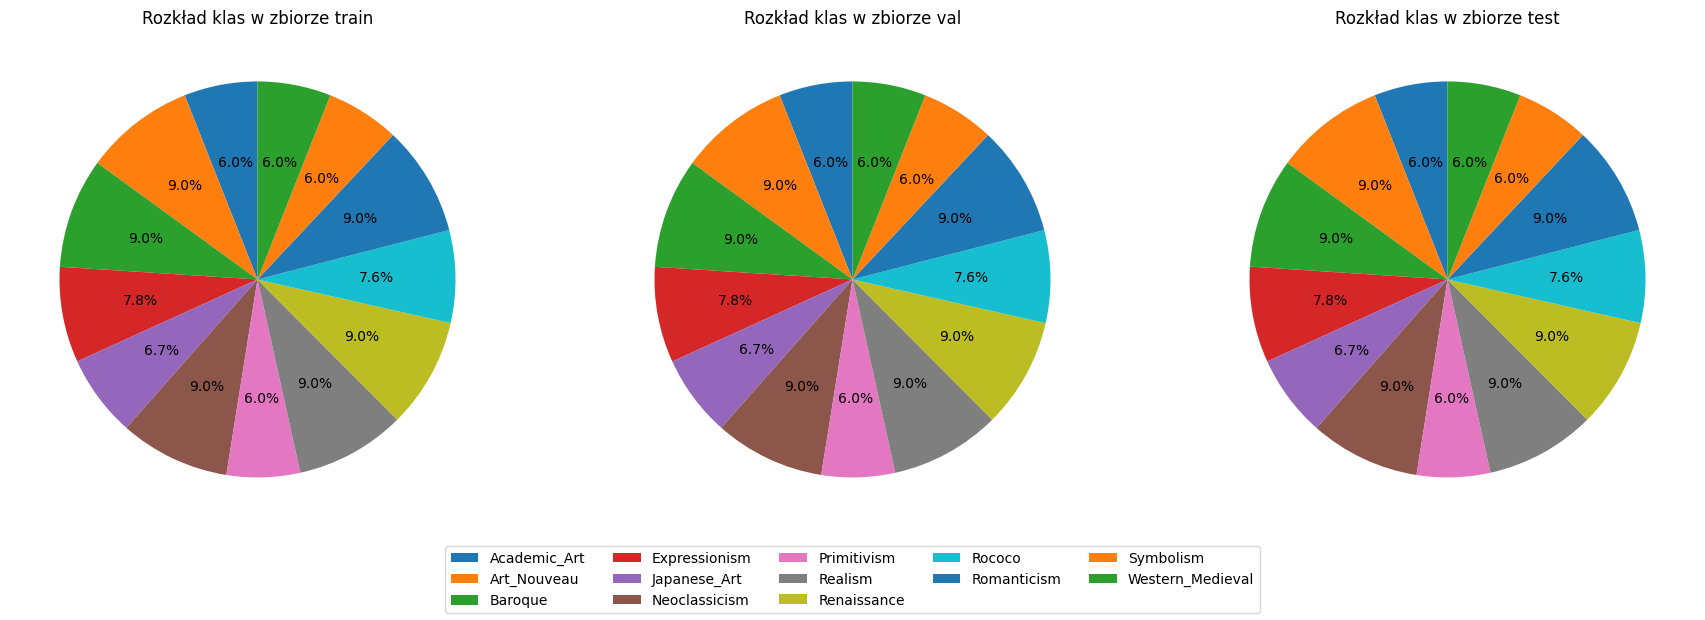

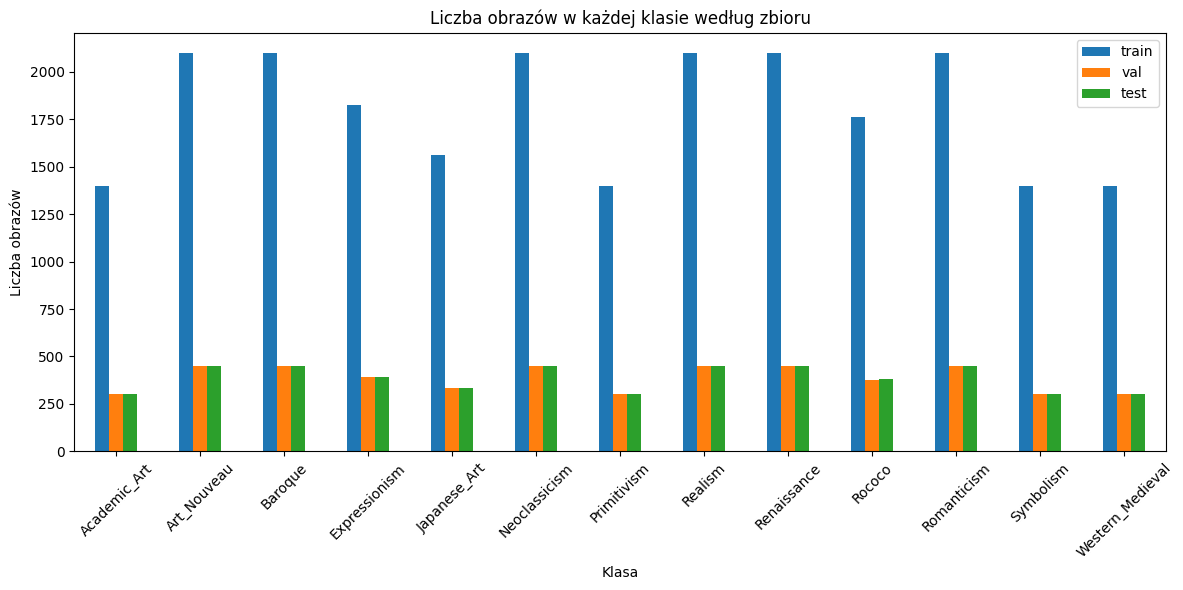

In [13]:
print("\n--- ETAP 3: Analiza rozkładu klas ---")
plot_class_distribution(dataset_stats)

In [14]:
print("\n--- ETAP 4: Tworzenie DataLoaderów ---")
data_loaders = create_data_loaders(
    split_dir,
    batch_size=batch_size,
    img_size=img_size
)


--- ETAP 4: Tworzenie DataLoaderów ---
Znaleziono 23351 obrazów w zbiorze train z 13 klasami
Znaleziono 5003 obrazów w zbiorze val z 13 klasami
Znaleziono 5007 obrazów w zbiorze test z 13 klasami



--- ETAP 5: Wizualizacja przykładów z każdej klasy ---


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2710083].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9124069..2.4831376].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0322802..2.535425].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.9208683].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.3412963].


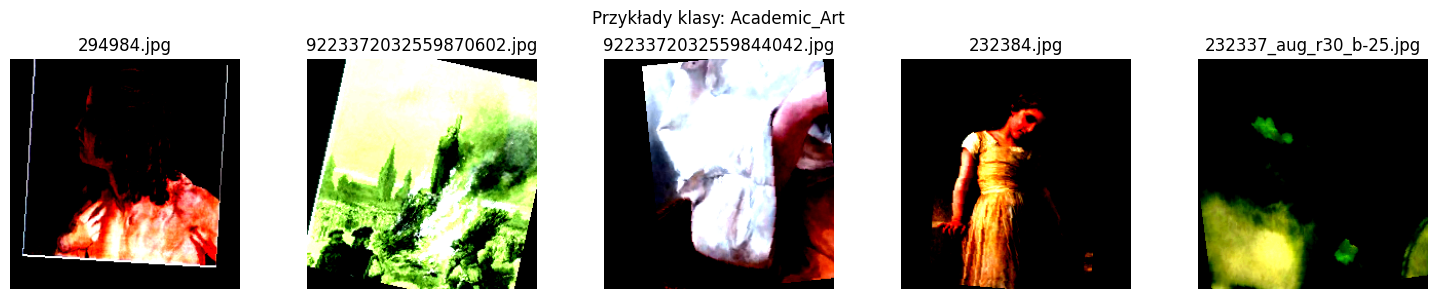

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2216995].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.5179958].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.169412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.3760502].


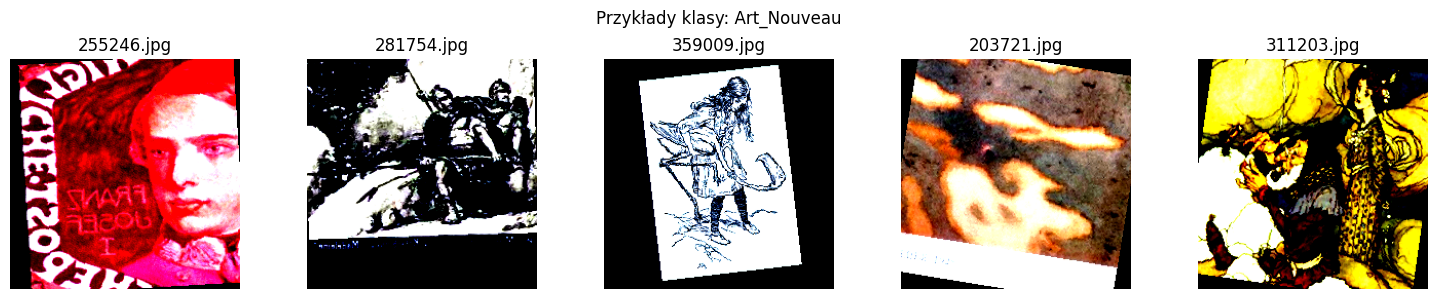

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.4097953].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9124069..2.129035].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.7633053].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5877128].


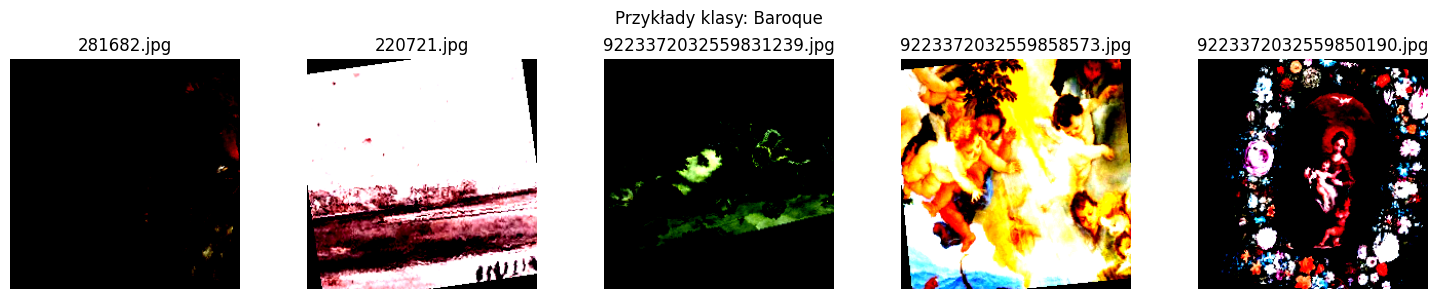

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.4373858].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9637812..2.1345534].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.465708].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.3611329].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.1519828].


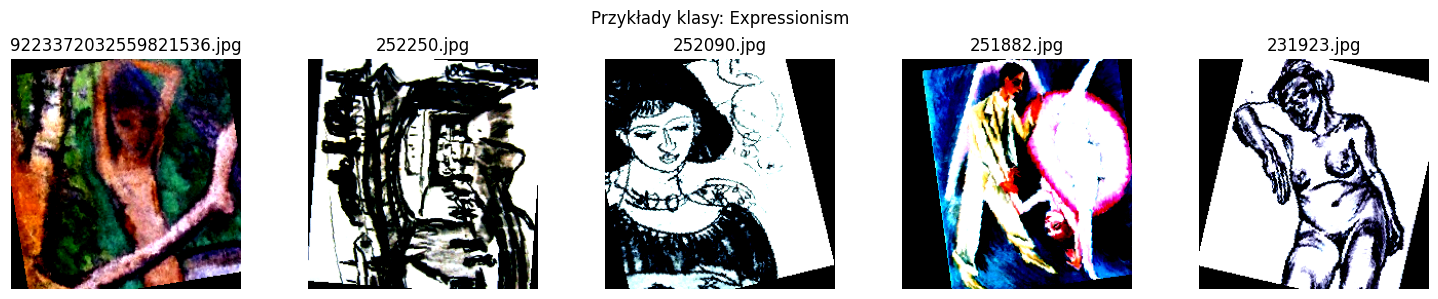

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0322802..2.0996952].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0322802..1.8382572].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2565577].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.9577874].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9466565..1.7522904].


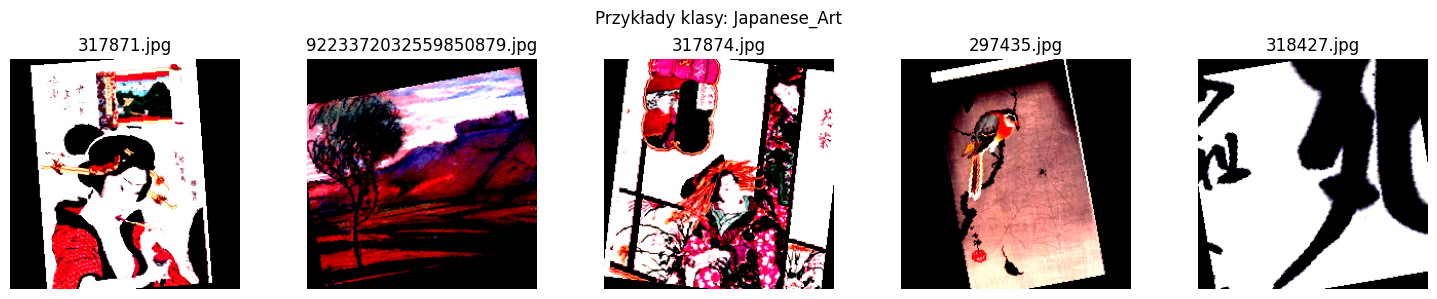

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0322802..2.4482791].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..1.6465361].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.7457983].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4482791].


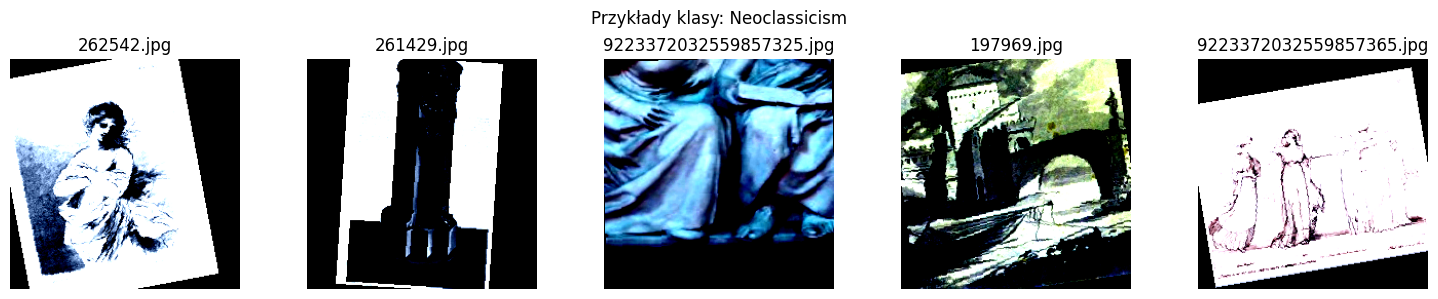

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8781574..2.465708].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.2146587].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.9908963].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3235295].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.7009162].


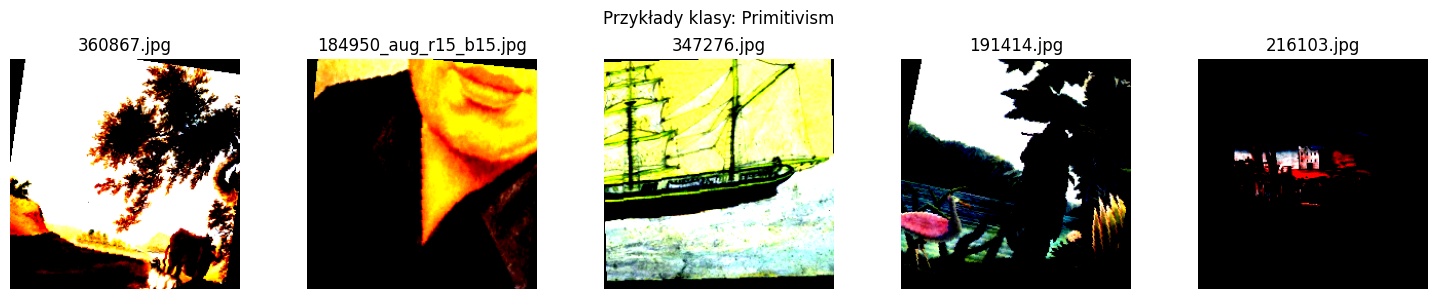

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.6495419].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.11191].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.6465361].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0322802..1.6116778].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9124069..2.0648367].


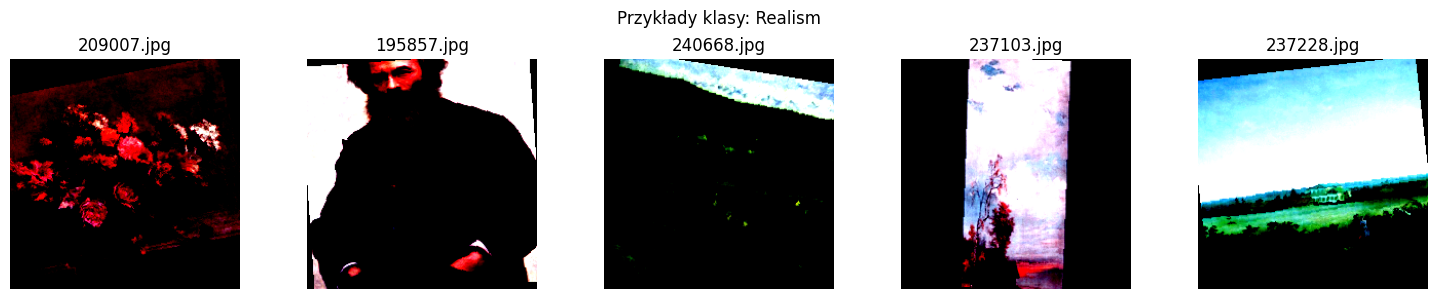

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0322802..2.2885156].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..1.5639181].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.5810429].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.1345534].


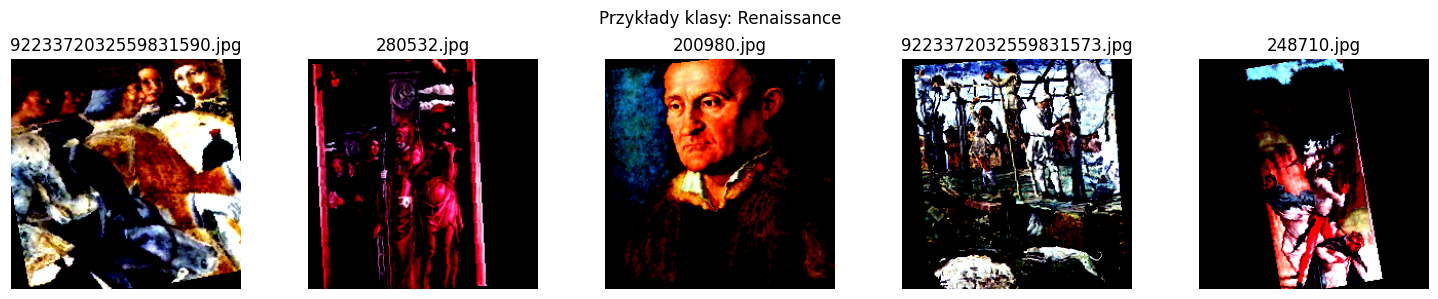

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..1.8207895].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.169412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3235295].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..1.8208281].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..0.8796516].


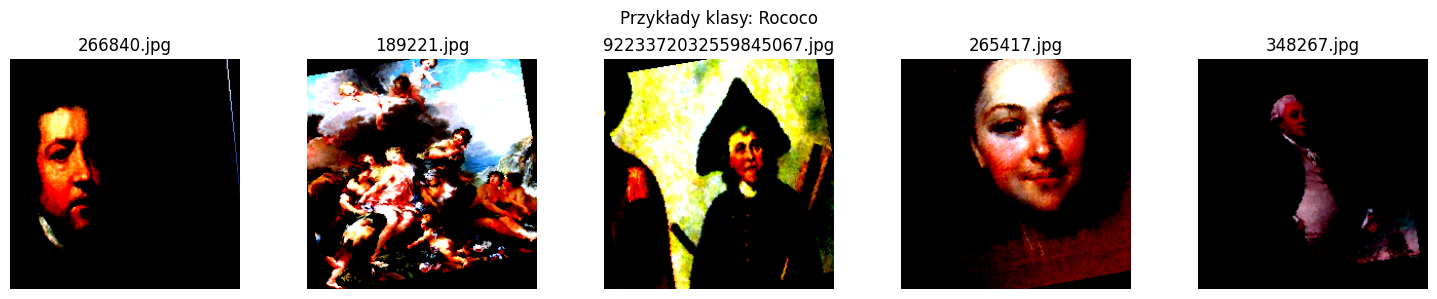

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.980906..2.0822659].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9637812..2.0262864].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2739873].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.1632845].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.0784314].


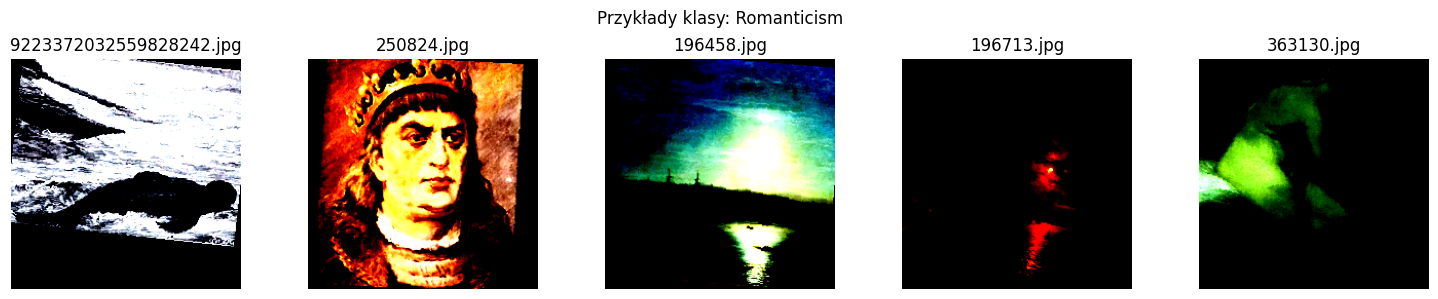

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2146587].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.0299783].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.1519828].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.733682].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.980906..1.8858544].


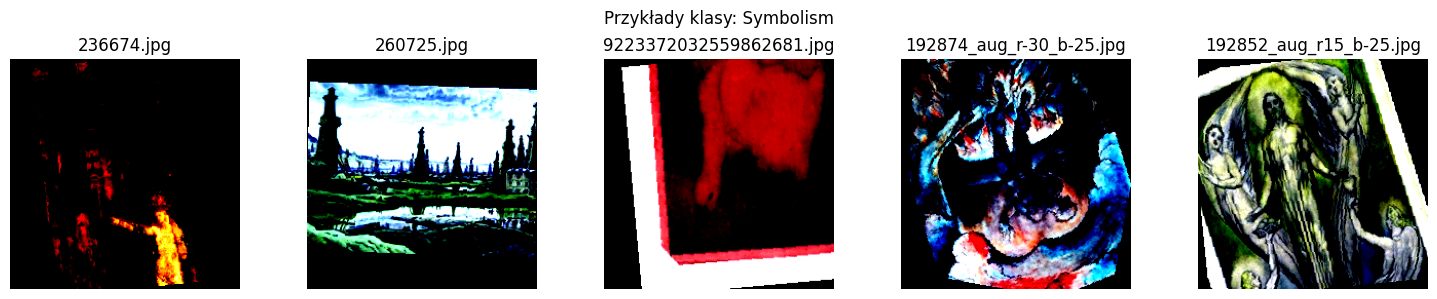

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.0959384].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.7522904].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.1171243].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.8379141].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.6837914].


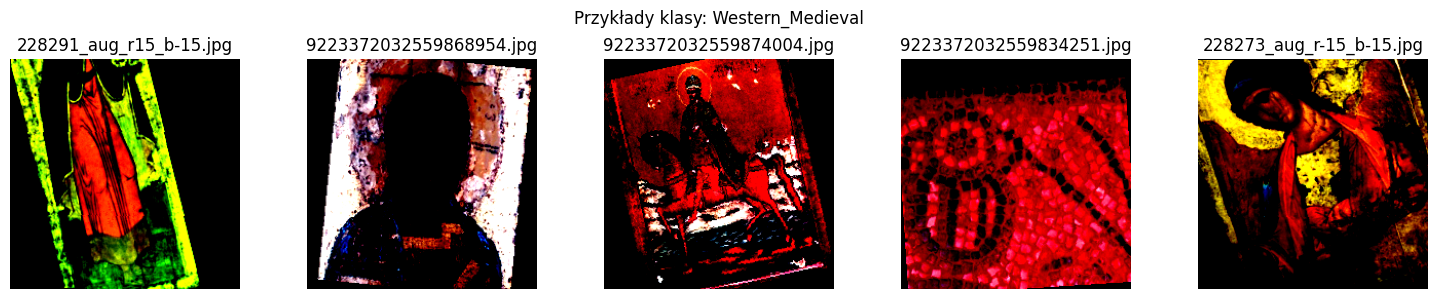

In [18]:
print("\n--- ETAP 5: Wizualizacja przykładów z każdej klasy ---")
plot_class_examples(data_loaders['train_dataset'])